In [1]:
# path = 'C:/Users/cokr3/OneDrive/바탕 화면/'

#### import module

In [2]:
import matplotlib    
import matplotlib.font_manager

[f.name for f in matplotlib.font_manager.fontManager.ttflist if 'Nanum' in f.name]
 # ['NanumBarunGothic',
 # 'NanumMyeongjo',
 # 'NanumMyeongjo',
 # 'NanumGothic',
 # 'NanumBarunGothic',
 # 'NanumGothic']

['NanumGothic',
 'NanumMyeongjo',
 'NanumMyeongjo',
 'NanumGothic',
 'NanumSquareRound',
 'NanumSquare',
 'NanumBarunGothic',
 'NanumSquareRound',
 'NanumBarunGothic',
 'NanumSquare']

In [3]:
import matplotlib
import matplotlib.pyplot as plt
# 유니코드 깨짐현상 해결
matplotlib.rcParams['axes.unicode_minus'] = False

# 나눔고딕 폰트 적용
plt.rcParams["font.family"] = 'NanumGothic'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import datetime 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,confusion_matrix
from sklearn.tree import export_graphviz
import graphviz
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.stats import shapiro
import scipy.stats as stats

from statsmodels.api import Logit
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import chi2_contingency, spearmanr

import warnings
warnings.filterwarnings("ignore")

# plt.rcParams['font.family'] = 'NanumGothic'
# matplotlib.rc("axes", unicode_minus = False)

In [5]:
plt.rcParams['font.family'] = 'NanumGothic'
matplotlib.rc('axes', unicode_minus=False)

- 사용자 지정 함수 생성

In [6]:
# 분류모델 통합 평가 함수
def eval_class_model(y_test, y_pred):
    confusion = confusion_matrix(y_test,y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test,y_pred)
    recall = f1_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    AUC = roc_auc_score(y_test,y_pred)
    print('혼돈행렬 : \n{}'.format(confusion))
    print('accuracy : {:.4f}'.format(accuracy))
    print('precision : {:.4f}'.format(precision))
    print('recall : {:.4f}'.format(recall))
    print('f1 : {:.4f}'.format(f1))
    print('AUC : {:.4f}'.format(AUC))


#### 데이터 불러오기

In [7]:
df_raw = pd.read_csv('SCALE불량.csv', encoding = "euc-kr")
df_raw.head()

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,116,1133,59,259,1133,TMCP(온도제어),934,8,1조
1,PLT_1002,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,122,1135,53,238,1135,TMCP(온도제어),937,8,1조
2,PLT_1003,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1129,116,1121,55,258,1121,TMCP(온도제어),889,8,1조
3,PLT_1004,03JAN2023:07:41:01,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1152,125,1127,68,266,1127,TMCP(온도제어),885,8,1조
4,PLT_1005,03JAN2023:07:52:40,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,...,1140,134,1128,48,246,1128,TMCP(온도제어),873,8,1조


- 데이터 변환  
y : 양품(0) 불량(1)    
rolling_method 삭제 (나라별 다른 규격)  
hsb 미적용시 모두 분량이므로, 미적용행 삭제 시 해당 열 삭제  

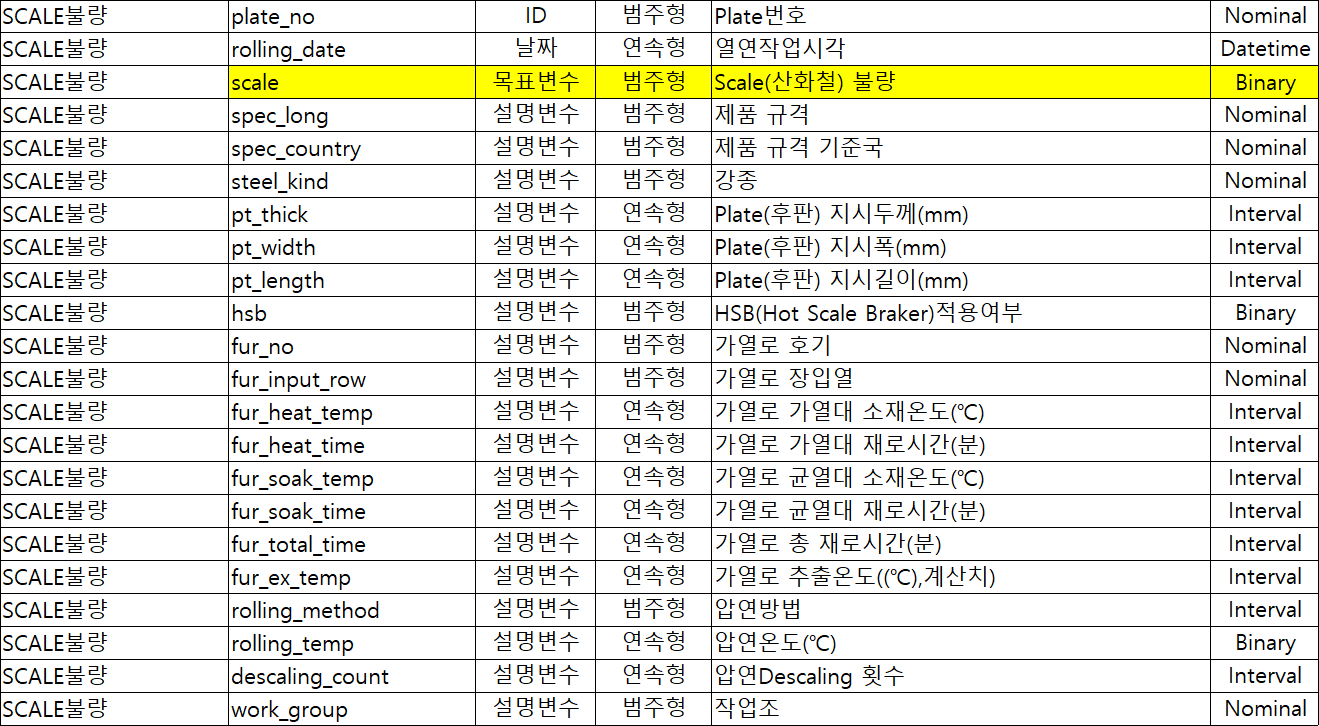![image.png]	설명변수	범주형	작업조	Nominal


In [8]:
"""
df_raw : 원본데이터
df : 분석을 위한 전처리가 끝난 데이터
"""

#0. 목표변수
df = df_raw.copy()
df.rename({"scale" : "y"}, axis = 1, inplace = True)

#1. plate_no, rolling_data, spec_long, fur_ex_temp 삭제
df = df.drop(["plate_no", "rolling_date", "spec_long", "fur_ex_temp"], axis = 1)

#2. value값 변환
df["rolling_method"] = df["rolling_method"].str.replace("(온도제어)", "",)
df["rolling_method"] = df["rolling_method"].str.replace("(제어압연)", "",)

#3. hsb 미적용 행 삭제 후 열 삭제
df = df[ df['hsb'] == "적용"].reset_index(drop = True)
df.drop("hsb", axis = 1, inplace = True)


__#1. plate_no, rolling_data, spec_long, fur_ex_temp 삭제__
1. plate_no은 제품의 고유번호이므로 분석과 관련이 없어 삭제
2. rolling_date와 y의 유의한 관계성 발견 불가
3. spec_long은 국가별로 다르기 때문에 국가를 범주로 사용
4. fur_ex_temp 동일 변수

__#2 .value값 변환__
데이터의 가독성을 위해 삭제

__#3. hsb__  
미적용시 모두 불량품인 것을 확인.  
아래 그래프 참조.

- 이상치 제거

In [9]:
df = df[ df["rolling_temp"] != 0].reset_index(drop = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   y                947 non-null    object
 1   spec_country     947 non-null    object
 2   steel_kind       947 non-null    object
 3   pt_thick         947 non-null    int64 
 4   pt_width         947 non-null    int64 
 5   pt_length        947 non-null    int64 
 6   fur_no           947 non-null    object
 7   fur_input_row    947 non-null    object
 8   fur_heat_temp    947 non-null    int64 
 9   fur_heat_time    947 non-null    int64 
 10  fur_soak_temp    947 non-null    int64 
 11  fur_soak_time    947 non-null    int64 
 12  fur_total_time   947 non-null    int64 
 13  rolling_method   947 non-null    object
 14  rolling_temp     947 non-null    int64 
 15  descaling_count  947 non-null    int64 
 16  work_group       947 non-null    object
dtypes: int64(10), object(7)
memory usag

압연온도가 0도인 것은 데이터상이나 이론적으로 불가한 데이터이므로 삭제

#### EDA

- object variance

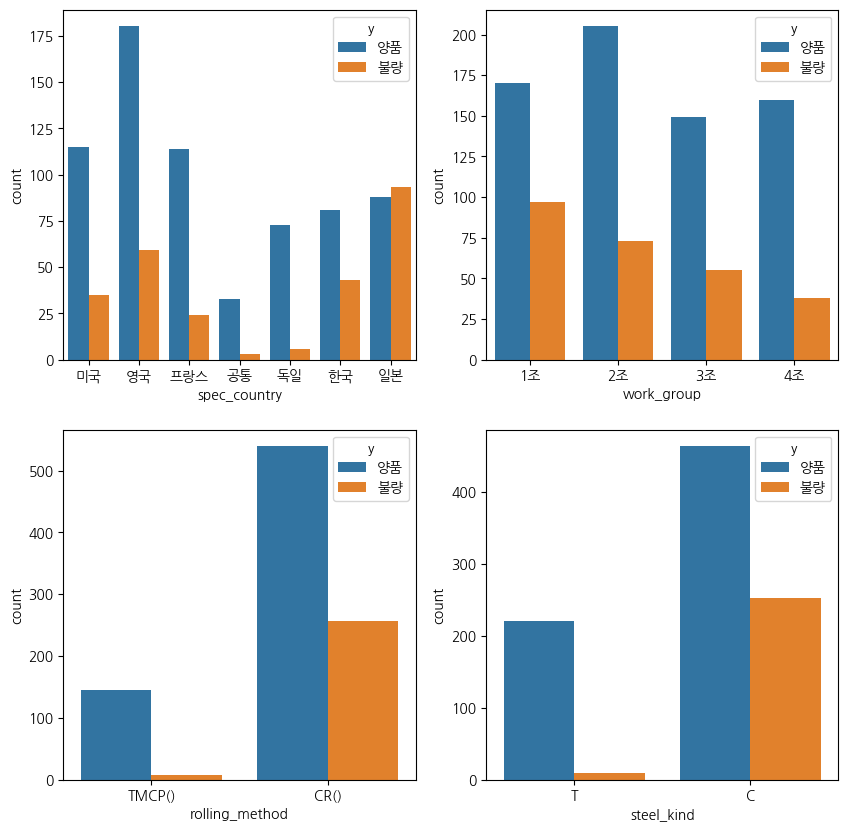

In [10]:
cat_cols = ['spec_country','work_group','rolling_method','steel_kind']
        
fig,axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))

for i,col in enumerate(cat_cols):
# #     0,0 0,1
# #     1,0 1,1
# #     2,0 2,1
     sns.countplot(x = col,hue = 'y', data = df, ax = axes[i//2][i%2])

- 국가 : 일본이 다른 나라에 비해 불량률이 높다.
- 압연방식 : CR방식이 불량수가 많이 나왔다. TMCP 방식은 불량이 거의 없다
- 철 종류 : 티타늄강의 불량이 거의 없다. 탄소강은 불량 개수가 티타늄 강에 비해 많다.

- numeric variance

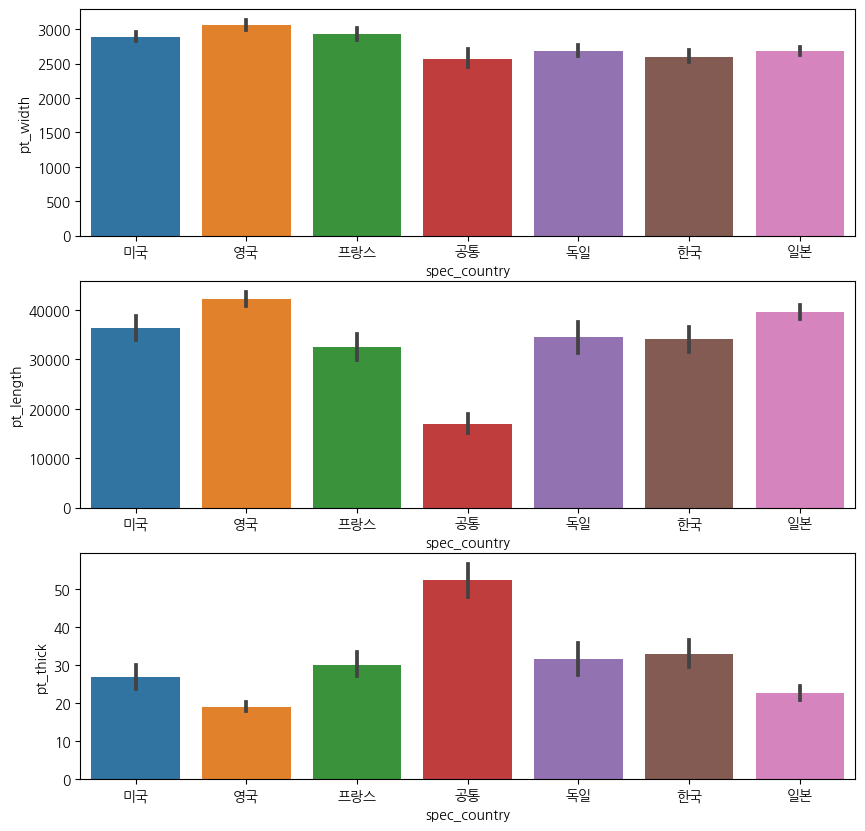

In [11]:
cols = ['pt_width','pt_length','pt_thick']

fig,axes = plt.subplots(nrows = 3, figsize = (10,10))
for i,col in enumerate(cols):
    sns.barplot(y =col,x='spec_country',data = df,ax = axes[i])

- 지시너비는 영국이 가장 넓고, 한국이 가장 낮은 편이다.
- 지시길이는 영국과 일본이 길고 프랑스가 가장 짧게 요구한다.
- 영국이 가장 얇은 두께의 후판을 요구한다. 

## 검증

1. work_group, fur_no, fur_input_row는 Y(scale)과 관련이 없다

In [12]:
df['y'] = df["y"].replace({ "양품" : 0 , "불량" : 1})

In [13]:
for i in ["work_group", "fur_no", "fur_input_row"] :
    correlation, p_value = spearmanr(df['y'], df[i])
    
    print("Spearman Correlation:", correlation)
    print("p-value:", p_value)
   
    print(i)
    if abs(correlation) < 0.5:
        print("Variables are not significantly correlated.")
    else:
        print("Variables are significantly correlated.")
    print()

Spearman Correlation: -0.1261895042252613
p-value: 9.871798017002286e-05
work_group
Variables are not significantly correlated.

Spearman Correlation: 0.03512270977910579
p-value: 0.28025370844481884
fur_no
Variables are not significantly correlated.

Spearman Correlation: -0.038387142538428155
p-value: 0.23793009070477011
fur_input_row
Variables are not significantly correlated.



2. 불량률과 지시길이, 지시폭, 지시두께의 관계성 파악

In [14]:
from scipy.stats import ttest_ind

#1. pt_length
good_quality = df.query('y == 0')['pt_length']
bad_quality = df.query('y == 1')['pt_length']

t_stat, p_value = ttest_ind(good_quality, bad_quality)
print("t_stat: ", t_stat, "\np_value: ",p_value, "\n")

#2. pt_width
good_quality = df.query('y == 0')['pt_width']
bad_quality = df.query('y == 1')['pt_width']

t_stat, p_value = ttest_ind(good_quality, bad_quality)
print("t_stat: ", t_stat, "\np_value: ",p_value, "\n")

#3. pt_thick
good_quality = df.query('y == 0')['pt_thick']
bad_quality = df.query('y == 1')['pt_thick']

t_stat, p_value = ttest_ind(good_quality, bad_quality)
print("t_stat: ", t_stat, "\np_value: ",p_value, "\n")

t_stat:  -1.2557055992748007 
p_value:  0.20953311025815502 

t_stat:  6.993478738930436 
p_value:  5.0692330506082475e-12 

t_stat:  3.1336025833588277 
p_value:  0.0017799751663510977 



### [결과]

#1. work_group, fur_no, fur_input_row는 Y(scale)과 관련이 없다
- Spearman Correlation의 절대값이 0.5 이하 일 경우 두 변수간의 _상관관계가 없다_

1. work_group : -0.126  
2. fur_no : 0.035  
3. fur_input_row : 0.238  

__work_group, fur_no, fur_inpur_row__ 는 Y와 관련성이 없다고 판단 -> 열 삭제 실행

#2. 불량률과 지시길이, 지시폭, 지시두께의 관계성 파악 

1. pt_length => t값이 음수이기에 불량품의 pt_length 평균이 양품보다 작음, p값은 0.05이상이므로 통계적으로 유의미하지 않음
2. pt_width => t값이 양수이므로 불량품의 pt_width가 평균이 불량품보다 큼, p값이 0.05이하이므로 통계적으로 유의미함
3. pt_thick => t값이 양수이므로 pt_thick 평균이 불량품보다 더 큼, p값이 0.05이하이므로 통계적으로 유의미
----------------------------------------------------------------------------------------------------------------------------------

- steel_kind의 __T__ 의 불량률은 __C__ 에 비해 _낮아_ 분석에서 제외한다

[불량률]  
__T__ :  4%  
__C__ :  35%  

teel_kind가 C(탄소강)일 경우 method가 CR 하나만 나타남. 따라서 고유값이 하나만 생기는 _steel_kind와 rolling_method를 삭제_

In [15]:
df = df[ df["steel_kind"] == "C" ].reset_index(drop = True)
df.drop( ["steel_kind", "rolling_method"], axis = 1, inplace = True)

상관성이 없는 _work_group, fur_no, fur_input_row_ 삭제

In [16]:
df.drop(["work_group", "fur_no", "fur_input_row"], axis = 1, inplace = True)
df.head()

,y,spec_country,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count
0,0,프랑스,20,3600,39300,1129,76,1126,118,297,934,8
1,0,프랑스,20,3600,39500,1140,68,1132,104,235,911,8
2,0,미국,17,3400,39600,1130,71,1130,112,240,935,10
3,0,영국,17,3400,39600,1130,71,1130,112,287,935,10
4,0,일본,14,3300,51200,1140,80,1131,117,286,915,10


## Data Set 만들기

- __numeric variance scaling__  
standard scaler

In [17]:
# y, x 분리
df_y = df[["y"]]
df_x = df.drop( "y", axis = 1 )

# scaling
df_num = df_x.select_dtypes(exclude = "object")
scaler = StandardScaler()

df_x_scaled = scaler.fit_transform(df_num)
df_x_scaled = pd.DataFrame(df_x_scaled, columns= df_num.columns )
df_x_scaled = pd.concat([ df_y, df_x_scaled ], axis = 1)

- __object variance scaling__  
one-hot encoding

In [18]:
df_chr = df.select_dtypes(include = "object")
ohe_df_all = pd.DataFrame()

for col in df_chr.columns:
    ohe = OneHotEncoder(sparse = False)
    ohe_data = ohe.fit_transform(df_chr[col].values.reshape(-1,1))
    ohe_df = pd.DataFrame(ohe_data, columns = df_chr[col].unique())
    ohe_df_all = pd.concat([ohe_df_all,ohe_df],axis=1)
    
df_x_encoded = pd.concat([df_y,ohe_df_all],axis = 1)

- __분석에 따른 DataFrame 생성__  
    - DT, RF, XGB => __df_c__  
    - 로지스틱 회귀분석 => __df_r__  

In [19]:
#1. one-hot encoding + scaling // 로지스틱
df_r = pd.concat([df_x_scaled, df_x_encoded.drop("y", axis = 1)], axis = 1)

#2. one-hot encoding // DF, RF, XGB
df_c = pd.concat( [df_y, df_num,  df_x_encoded.drop("y", axis = 1)], axis = 1)

df_c_y = df_c[['y']]
df_c_x = df_c.drop('y',axis = 1)

# 모델링

- 학습 / 테스트 데이터 분리

In [20]:
df_c_train,df_c_test = train_test_split(df_c, test_size = 0.2, stratify = df_c['y'],random_state = 2024)
df_train_x = df_c_train.drop('y',axis = 1)
df_train_y = df_c_train['y']

df_test_x = df_c_test.drop('y',axis = 1)
df_test_y = df_c_test['y']
print(df_train_x.shape,df_test_x.shape)

(572, 16) (144, 16)


## 1. Decision Tree

In [21]:
from sklearn.tree import DecisionTreeClassifier

- 초기 모델 생성

In [22]:
tree_uncust = DecisionTreeClassifier(random_state = 2024)
tree_uncust.fit(df_train_x,df_train_y)

print('Score on training set : {:.3f}'.format(tree_uncust.score(df_train_x,df_train_y)))
print('Score on test set : {:.3f}'.format(tree_uncust.score(df_test_x,df_test_y)))

Score on training set : 1.000
Score on test set : 1.000


## 파라미터 튜닝

### 잎사귀 노드 최소 자료수 min_samples_leaf

In [23]:
train_accuracy = []; test_accuracy = []

# min_samples_leaf: 잎사귀 수 제한
para_leaf = [n_leaf for n_leaf in range(1, 41)]

for v_min_samples_leaf in para_leaf:
    dt = DecisionTreeClassifier(min_samples_leaf = v_min_samples_leaf,random_state = 2024)
    dt.fit(df_train_x, df_train_y)
    train_accuracy.append(dt.score(df_train_x, df_train_y))
    test_accuracy.append(dt.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,1,1.000000,1.000000
1,2,0.998252,0.993056
2,3,0.998252,1.000000
3,4,0.998252,1.000000
4,5,0.998252,1.000000
5,6,0.998252,1.000000
6,7,0.998252,1.000000
7,8,0.989510,0.979167
8,9,0.989510,0.979167
9,10,0.989510,0.979167


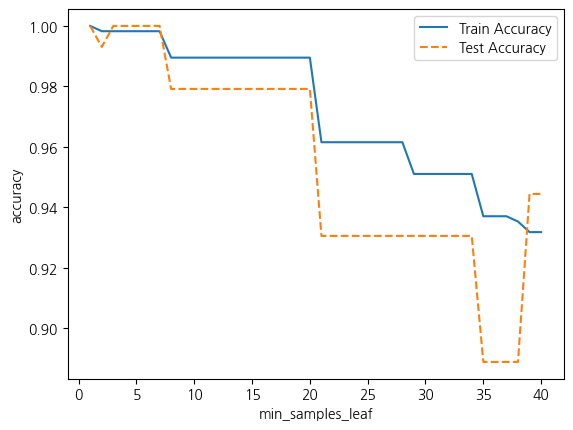

In [24]:
# 모델 정확도 그래프 확인
display(df_accuracy_leaf)
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min_samples_leaf"); plt.ylabel("accuracy")
plt.legend()

- min_samples_leaf = __30__ 결정

In [25]:
train_accuracy = []; test_accuracy = []

# min_samples_leaf: 잎사귀 수 제한
para_split = [s*2 for s in range(10, 20)]

for split_ in para_split:
    dt = DecisionTreeClassifier(min_samples_leaf = 30, min_samples_split = split_,random_state = 2024)
    dt.fit(df_train_x, df_train_y)
    train_accuracy.append(dt.score(df_train_x, df_train_y))
    test_accuracy.append(dt.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesSplit"] = para_split
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,20,0.951049,0.930556
1,22,0.951049,0.930556
2,24,0.951049,0.930556
3,26,0.951049,0.930556
4,28,0.951049,0.930556
5,30,0.951049,0.930556
6,32,0.951049,0.930556
7,34,0.951049,0.930556
8,36,0.951049,0.930556
9,38,0.951049,0.930556


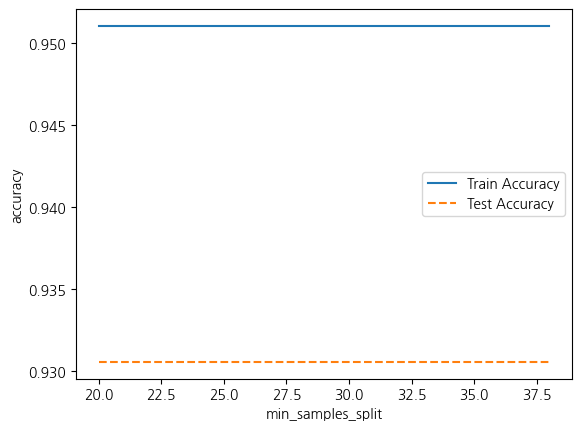

In [26]:
# 모델 정확도 그래프 확인
display(df_accuracy_leaf)
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min_samples_split"); plt.ylabel("accuracy")
plt.legend()

- 분리 노드 자료수와 성능은 관련이 없는 것으로 보이니 __디폴트 값__ 으로 결정

### 최대깊이

In [27]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_leaf: 잎사귀 수 제한
para_depth = [d for d in range(1, 8)]

for d in para_depth:
    dt = DecisionTreeClassifier(min_samples_leaf = 30,max_depth = d,random_state = 2024)
    dt.fit(df_train_x, df_train_y)
    train_accuracy.append(dt.score(df_train_x, df_train_y))
    test_accuracy.append(dt.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["MaxDepth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

,MaxDepth,TrainAccuracy,TestAccuracy
0,1,0.905594,0.895833
1,2,0.944056,0.958333
2,3,0.944056,0.958333
3,4,0.951049,0.930556
4,5,0.951049,0.930556
5,6,0.951049,0.930556
6,7,0.951049,0.930556


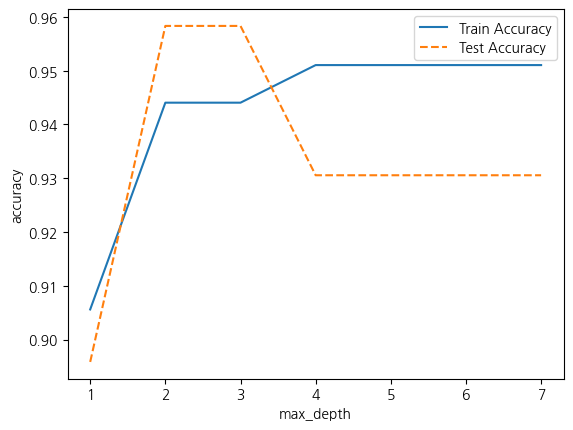

In [28]:
# 모델 정확도 그래프 확인
display(df_accuracy_depth)
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("max_depth"); plt.ylabel("accuracy")
plt.legend()

- max_depth = __4__ 결정

### 의사결정나무 최종 모델
- max_depth = 4
- min_samples_leaf = 30

In [29]:
v_feature_name = df_train_x.columns
tree_final = DecisionTreeClassifier(min_samples_leaf = 30,max_depth = 4,random_state = 2024)
tree_final.fit(df_train_x,df_train_y)

train_score = []
test_score = [] 

# 학습 데이터로 모델 정확도 측정 
train_score.append(tree_final.score(df_train_x, df_train_y))
print('train data Accuray', train_score)

test_score.append(tree_final.score(df_test_x, df_test_y))
print('test data Accuray', test_score)

pred = tree_final.predict(df_test_x)
# 테스트 데이터로 모델 정확도 측정 
tree_final.score(df_test_x, df_test_y) 
accuracy_score(df_test_y, pred) 

train data Accuray [0.951048951048951]
test data Accuray [0.9305555555555556]


0.9305555555555556

In [30]:
train_pred = tree_final.predict(df_train_x)
test_pred = tree_final.predict(df_test_x)

print('Train 성능')
eval_class_model(df_train_y,train_pred)


Train 성능
혼돈행렬 : 
[[349  21]
 [  7 195]]
accuracy : 0.9510
precision : 0.9028
recall : 0.9330
f1 : 0.9330
AUC : 0.9543


In [31]:
print('Test 성능')
eval_class_model(df_test_y, test_pred)

Test 성능
혼돈행렬 : 
[[85  8]
 [ 2 49]]
accuracy : 0.9306
precision : 0.8596
recall : 0.9074
f1 : 0.9074
AUC : 0.9374


1. test의 accuracy _감소_
2. test의 precision _감소_
3. test의 reacll _감소_
4. test의 F1-score _감소_
5. test의 AUC _감소_

소폭 감소로 모델 성능에 문제가 없는 것으로 판단된다

In [32]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = tree_final.feature_importances_

df_importance.sort_values('Importance', ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
8,rolling_temp,0.750
5,fur_soak_temp,0.161
9,descaling_count,0.058
2,pt_length,0.031
0,pt_thick,0.000
1,pt_width,0.000
3,fur_heat_temp,0.000
4,fur_heat_time,0.000
6,fur_soak_time,0.000
7,fur_total_time,0.000


Text(0, 0.5, 'feature')

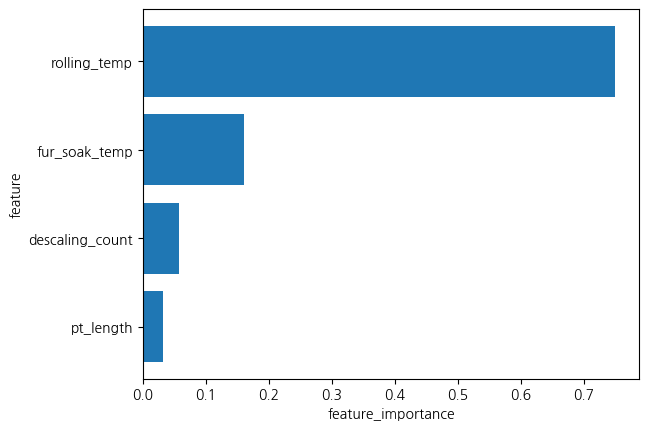

In [33]:
# 설명변수 중요도 그래프
df_importance = df_importance[df_importance["Importance"] > 0.005]
df_importance.sort_values('Importance', ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('feature_importance')
plt.ylabel('feature')

- 스케일 불량에 영향을 주는 변수는 압연 온도, 균열대 온도, 지시 두께, 압연(디스케일링) 횟수이다.

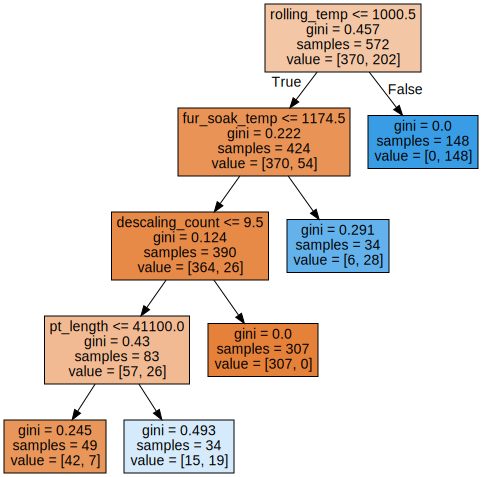

In [34]:
export_graphviz(tree_final, out_file = 'posco_tree_final2.dot',
               feature_names = v_feature_name, impurity = True, filled = True)

with open('posco_tree_final2.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [35]:
y_test_pred = tree_final.predict(df_test_x)
cf_tree = confusion_matrix(df_test_y,y_test_pred)

tpr = cf_tree[1][0] /(cf_tree[1][0] + cf_tree[1][1])
tpr
print(1-tpr)

0.9607843137254902


In [36]:
models = ['DecisionTree','RandomForest','XGBoost','LogisticRegressor']

accuracy = []
f1 = []
recall = []
precision = []
speci = []

tree_pred = tree_final.predict(df_test_x)

accuracy.append(accuracy_score(df_test_y,tree_pred))
f1.append(f1_score(df_test_y,tree_pred))
recall.append(recall_score(df_test_y, tree_pred))
precision.append(precision_score(df_test_y,tree_pred))
speci.append(1-tpr)

## 2. RandomForest

- 초기 모델 생성

In [37]:
# 기본 모델
rfr = RandomForestClassifier(random_state = 2024)
rfr.fit(df_train_x, df_train_y)
print('Score on training set : {:.3f}'.format(rfr.score(df_train_x,df_train_y)))
print('Score on test set : {:.3f}'.format(rfr.score(df_test_x,df_test_y)))

Score on training set : 1.000
Score on test set : 0.986


## 파라미터 튜닝

#### n_estimators 트리수

In [38]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# n_estimatos: 트리 수 변경
para_n_tree = [n_tree * 10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    rf = RandomForestClassifier(n_estimators = v_n_estimators,random_state = 2024)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n["n_estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

,n_estimators,TrainAccuracy,TestAccuracy
0,10,1.0,0.979167
1,20,1.0,0.979167
2,30,1.0,0.986111
3,40,1.0,0.979167
4,50,1.0,0.979167
5,60,1.0,0.986111
6,70,1.0,0.986111
7,80,1.0,0.993056
8,90,1.0,0.993056
9,100,1.0,0.986111


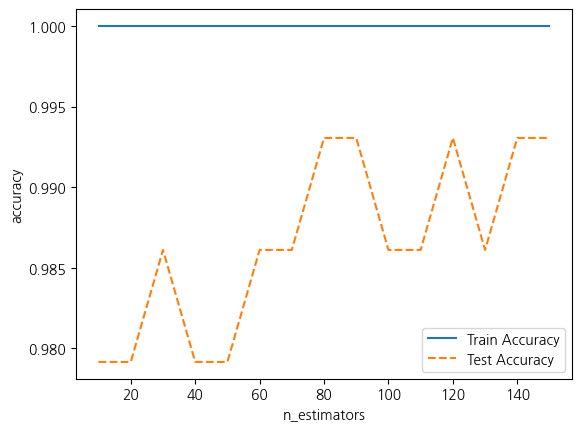

In [39]:
# 모델 정확도 그래프 확인
display(df_accuracy_n)
plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("n_estimators"); plt.ylabel("accuracy")
plt.legend()

- n_estimators = __20__

- 분리 노드 최소 자료수

In [40]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_split: 분할하기 위한 노드의 최소 샘플 수.
para_split = [n_split * 2 for n_split in range(15, 42)]

for v_min_samples_split in para_split:
    rf = RandomForestClassifier(min_samples_split = v_min_samples_split,n_estimators = 20,random_state = 2024)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,30,0.989510,0.979167
1,32,0.991259,0.979167
2,34,0.991259,0.979167
3,36,0.984266,0.979167
4,38,0.980769,0.979167
5,40,0.979021,0.979167
6,42,0.975524,0.979167
7,44,0.975524,0.972222
8,46,0.972028,0.965278
9,48,0.975524,0.965278


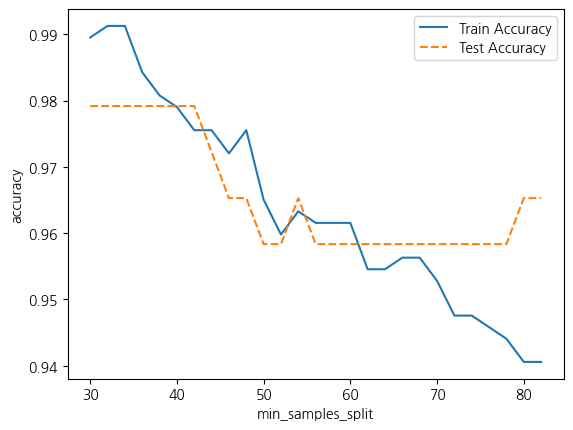

In [41]:
# 모델 정확도 그래프 확인
display(df_accuracy_split)
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min_samples_split"); plt.ylabel("accuracy")
plt.legend()

- 분리 노드 최소 자료수 __50__ 결정

#### 최대 깊이 조정

In [42]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_split: 분할하기 위한 노드의 최소 샘플 수.
m_depth = [m for m in range(1, 11)]

for m in m_depth:
    rf = RandomForestClassifier(max_depth = m, n_estimators = 20,min_samples_split = 50, random_state = 2024)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["MaxDepth"] = m_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

,MaxDepth,TrainAccuracy,TestAccuracy
0,1,0.905594,0.895833
1,2,0.907343,0.902778
2,3,0.937063,0.944444
3,4,0.947552,0.951389
4,5,0.952797,0.958333
5,6,0.958042,0.958333
6,7,0.958042,0.958333
7,8,0.963287,0.958333
8,9,0.963287,0.958333
9,10,0.965035,0.958333


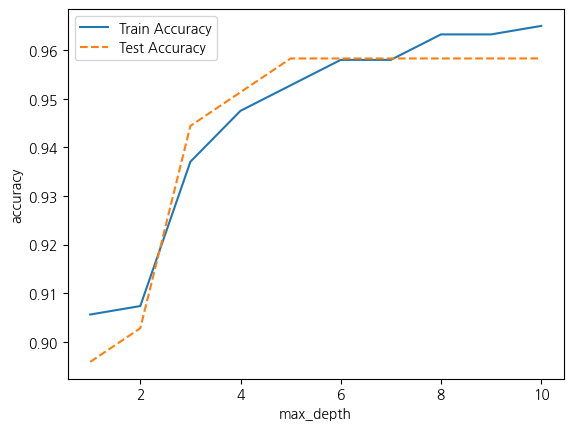

In [43]:
# 모델 정확도 그래프 확인
display(df_accuracy_depth)
plt.plot(m_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(m_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("max_depth"); plt.ylabel("accuracy")
plt.legend()

- 최대 깊이 __2__ 로 결정

### 최종모델
- max_depth = 2
- n_estimators = 20
- min_samples_split = 50

In [44]:
# rfr = RandomForestClassifier(max_depth=3, n_estimators=20,min_samples_split = 50, random_state = 2024)
# rfr.fit(df_train_x, df_train_y)

In [45]:
v_feature_name = df_train_x.columns

rfr = RandomForestClassifier(max_depth=2, n_estimators=20,min_samples_split = 50, random_state = 2024)
rfr.fit(df_train_x, df_train_y)

train_score = []
test_score = [] 

# 학습 데이터로 모델 정확도 측정 
train_score.append(rfr.score(df_train_x, df_train_y))
print('train data Accuray', train_score)

test_score.append(rfr.score(df_test_x, df_test_y))
print('test data Accuray', test_score)

pred = rfr.predict(df_test_x)
# 테스트 데이터로 모델 정확도 측정 
# rfr.score(df_test_x, df_test_y) 
# accuracy_score(df_test_y, pred)

train data Accuray [0.9073426573426573]
test data Accuray [0.9027777777777778]


In [46]:
y_train_pred = rfr.predict(df_train_x)
print('Train 성능\n')
print(eval_class_model(df_train_y,y_train_pred))

y_test_pred = rfr.predict(df_test_x)
print('Test 성능\n')
print(eval_class_model(df_test_y,y_test_pred))

Train 성능

혼돈행렬 : 
[[370   0]
 [ 53 149]]
accuracy : 0.9073
precision : 1.0000
recall : 0.8490
f1 : 0.8490
AUC : 0.8688
None
Test 성능

혼돈행렬 : 
[[93  0]
 [14 37]]
accuracy : 0.9028
precision : 1.0000
recall : 0.8409
f1 : 0.8409
AUC : 0.8627
None


1. test의 accuracy _감소_
2. test의 precision _유지_
3. test의 reacll _감소_
4. test의 F1-score _감소_
5. test의 AUC _감소_

소폭 감소로 모델 성능에 문제가 없는 것으로 판단된다

In [47]:
# 실제 불량으로 판명된 제품을 정확하게 불량으로 예측할 확률
y_test_pred = rfr.predict(df_test_x)
cf_rfr = confusion_matrix(df_test_y,y_test_pred)

tpr = cf_rfr[1][0] /(cf_rfr[1][0] + cf_rfr[1][1])
tpr
print(1-tpr)

0.7254901960784313


### 피처 중요도

In [48]:
v_feature_name = df_train_x.columns
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rfr.feature_importances_

df_importance.sort_values('Importance', ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
8,rolling_temp,0.549
9,descaling_count,0.236
0,pt_thick,0.111
3,fur_heat_temp,0.042
2,pt_length,0.025
1,pt_width,0.020
6,fur_soak_time,0.007
14,한국,0.006
5,fur_soak_temp,0.003
7,fur_total_time,0.001


Text(0, 0.5, 'feature')

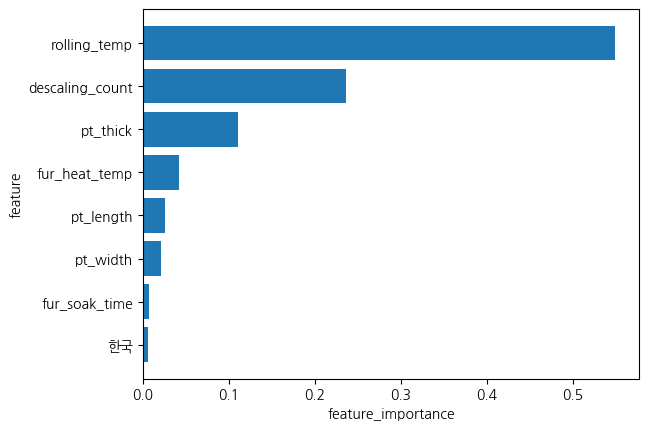

In [49]:
# 설명변수 중요도 그래프
df_importance = df_importance[df_importance["Importance"] > 0.005]
df_importance.sort_values('Importance', ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('feature_importance')
plt.ylabel('feature')

- 불량 여부에 압연 온도, 압연 횟수, 지시 두께가 가장 중요하다는 결론이 나왔다.
- 의사결정나무와 동일하게 압연 온도가 가장 불량에 영향을 많이 주는 변수라는 예측을 하였다.

In [50]:
rfr_pred = rfr.predict(df_test_x)

accuracy.append(accuracy_score(df_test_y,rfr_pred))
f1.append(f1_score(df_test_y,rfr_pred))
recall.append(recall_score(df_test_y, rfr_pred))
precision.append(precision_score(df_test_y,rfr_pred))
speci.append(1-tpr)

## 3. XGBoostClassifier

- 초기 모델 생성

In [51]:
xgb_uncust = XGBClassifier(random_state = 2024)
xgb_uncust.fit(df_train_x,df_train_y)

print('\n>>>> train <<<<\n')
xgb_train_pred = xgb_uncust.predict(df_train_x)
eval_class_model(df_train_y, xgb_train_pred)

print('\n>>>> test <<<<\n')
xgb_test_pred = xgb_uncust.predict(df_test_x)
eval_class_model(df_test_y,xgb_test_pred)


>>>> train <<<<

혼돈행렬 : 
[[370   0]
 [  0 202]]
accuracy : 1.0000
precision : 1.0000
recall : 1.0000
f1 : 1.0000
AUC : 1.0000

>>>> test <<<<

혼돈행렬 : 
[[93  0]
 [ 0 51]]
accuracy : 1.0000
precision : 1.0000
recall : 1.0000
f1 : 1.0000
AUC : 1.0000


#### n_estimators 트리수

,n_estimators,Train score,Test score
0,10,0.998,1.000
1,20,0.998,1.000
2,30,1.000,1.000
3,40,1.000,1.000
4,50,1.000,1.000
5,60,1.000,1.000
6,70,1.000,1.000
7,80,1.000,1.000
8,90,1.000,1.000
9,100,1.000,1.000


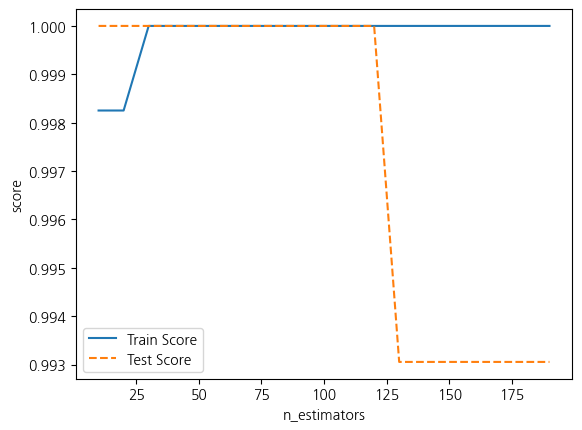

In [52]:
train_score = []
test_score = []

n_est = [n_tree * 10 for n_tree in range(1,20)]

for n in n_est:
    xgb_model = XGBClassifier(n_estimators = n,random_state = 2024)
    xgb_model.fit(df_train_x, df_train_y)
    train_score.append(xgb_model.score(df_train_x,df_train_y))
    test_score.append(xgb_model.score(df_test_x,df_test_y))

df_score_trees = pd.DataFrame()    
df_score_trees['n_estimators'] = n_est
df_score_trees['Train score'] = train_score
df_score_trees['Test score'] = test_score

display(df_score_trees.round(3))

plt.plot(n_est, train_score, linestyle = '-', label = 'Train Score')
plt.plot(n_est, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score')
plt.xlabel('n_estimators')
plt.legend()

n_estimators는 모델 성능에 영향을 주지 않는 것으로 보이므로 디폴트 값 결정

#### 세부적으로 분석

In [53]:
# train_score = []
# test_score = []

# n_est = [n_tree for n_tree in range(1,20)]

# for n in n_est:
#     xgb_model = XGBClassifier(n_estimators = n,random_state = 2024)
#     xgb_model.fit(df_train_x, df_train_y)
#     train_score.append(xgb_model.score(df_train_x,df_train_y))
#     test_score.append(xgb_model.score(df_test_x,df_test_y))

# df_score_trees = pd.DataFrame()    
# df_score_trees['n_estimators'] = n_est
# df_score_trees['Train score'] = train_score
# df_score_trees['Test score'] = test_score

# display(df_score_trees.round(3))

# plt.plot(n_est, train_score, linestyle = '-', label = 'Train Score')
# plt.plot(n_est, test_score, linestyle = '--', label = 'Test Score')
# plt.ylabel('score')
# plt.xlabel('n_estimators')
# plt.legend()

- n_estimators 디폴트 결정

#### 잎사귀 노드 최소 자료수 조정

,m_split,Train score,Test score
0,2,1.0,1.0
1,4,1.0,1.0
2,6,1.0,1.0
3,8,1.0,1.0
4,10,1.0,1.0
5,12,1.0,1.0
6,14,1.0,1.0
7,16,1.0,1.0
8,18,1.0,1.0
9,20,1.0,1.0


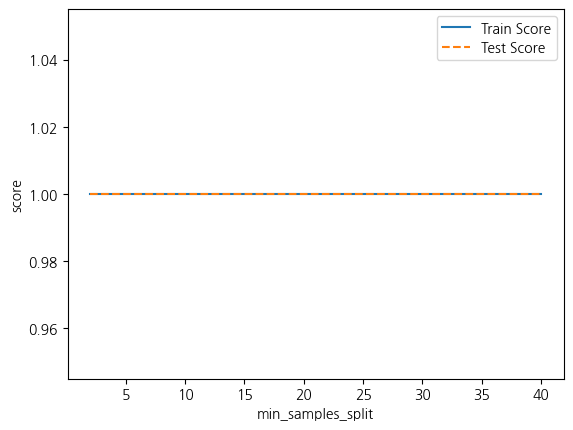

In [54]:
train_score = []
test_score = []

para_split = [n_split * 2 for n_split in range(1,21)]

for split_ in para_split:
    xgb_model = XGBClassifier(min_samples_split = split_,random_state = 2024)
    xgb_model.fit(df_train_x, df_train_y)
    train_score.append(xgb_model.score(df_train_x,df_train_y))
    test_score.append(xgb_model.score(df_test_x,df_test_y))

df_score_split = pd.DataFrame()    
df_score_split['m_split'] = para_split
df_score_split['Train score'] = train_score
df_score_split['Test score'] = test_score

display(df_score_split.round(3))

plt.plot(para_split, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_split, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score')
plt.xlabel('min_samples_split')
plt.legend()

- 잎사귀 노드 최소 자료수도 모델 성능에 영향을 주지 않는다. 디폴트 값으로 결정

#### max_depth 튜닝

,m_depth,Train score,Test score
0,1,0.998,1.0
1,2,1.000,1.0
2,3,1.000,1.0
3,4,1.000,1.0
4,5,1.000,1.0
5,6,1.000,1.0
6,7,1.000,1.0
7,8,1.000,1.0
8,9,1.000,1.0
9,10,1.000,1.0


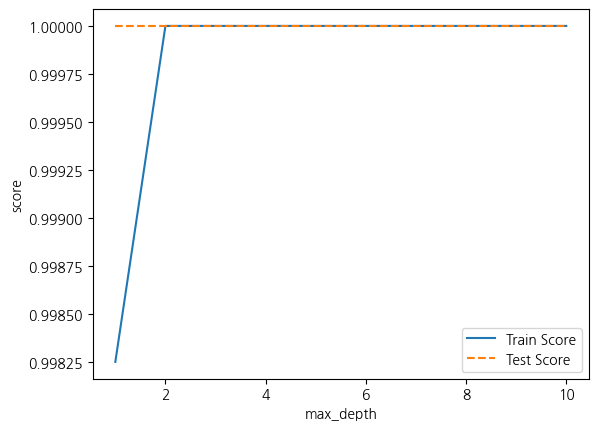

In [55]:
train_score = []
test_score = []

m_depth = [m for m in range(1,11)]

for m in m_depth:
    xgb_model = XGBClassifier(max_depth = m,random_state = 2024)
    xgb_model.fit(df_train_x, df_train_y)
    train_score.append(xgb_model.score(df_train_x,df_train_y))
    test_score.append(xgb_model.score(df_test_x,df_test_y))

df_score_depth = pd.DataFrame()    
df_score_depth['m_depth'] = m_depth
df_score_depth['Train score'] = train_score
df_score_depth['Test score'] = test_score

display(df_score_depth.round(3))

plt.plot(m_depth, train_score, linestyle = '-', label = 'Train Score')
plt.plot(m_depth, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score')
plt.xlabel('max_depth')
plt.legend()

- max_depth = 3으로 결정

#### 학습률 튜닝

,learning_rate,Train score,Test score
0,0.005,0.955,0.958
1,0.010,0.955,0.958
2,0.015,0.955,0.958
3,0.020,0.955,0.958
4,0.025,0.955,0.958
5,0.030,0.990,0.979
6,0.035,0.991,0.979
7,0.040,0.998,1.000
8,0.045,0.998,1.000
9,0.050,0.998,1.000


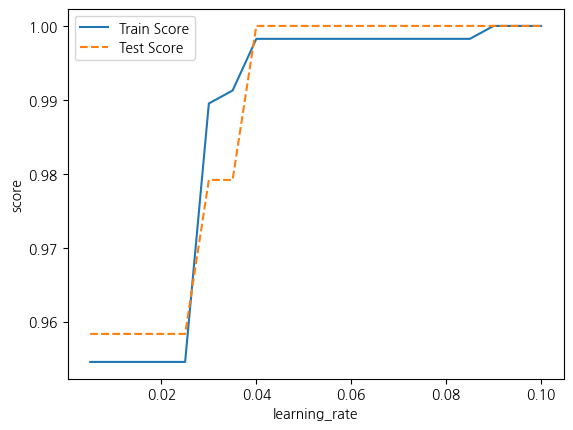

In [56]:

train_score = []
test_score = []

lrs = [l * 0.005 for l in range(1, 21)]

for lr in lrs:
    xgb_model = XGBClassifier(max_depth = 3,learning_rate = lr,random_state = 2024)
    xgb_model.fit(df_train_x, df_train_y)
    train_score.append(xgb_model.score(df_train_x,df_train_y))
    test_score.append(xgb_model.score(df_test_x,df_test_y))

df_score_lr = pd.DataFrame()    
df_score_lr['learning_rate'] = lrs
df_score_lr['Train score'] = train_score
df_score_lr['Test score'] = test_score

display(df_score_lr.round(3))

plt.plot(lrs, train_score, linestyle = '-', label = 'Train Score')
plt.plot(lrs, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score')
plt.xlabel('learning_rate')
plt.legend()

- 학습률 0.03으로 결정

## XGBoost 최종모델
- learning_rate = 0.03
- max_depth = 3


In [57]:
xgb_final = XGBClassifier(max_depth = 3,learning_rate = 0.03,random_state = 2024)
xgb_final.fit(df_train_x, df_train_y)

print('Score on train : {:.3f}'.format(xgb_final.score(df_train_x,df_train_y)))
print('score on test : {:.3f}'.format(xgb_final.score(df_test_x,df_test_y)))

Score on train : 0.990
score on test : 0.979


Text(0, 0.5, 'feature')

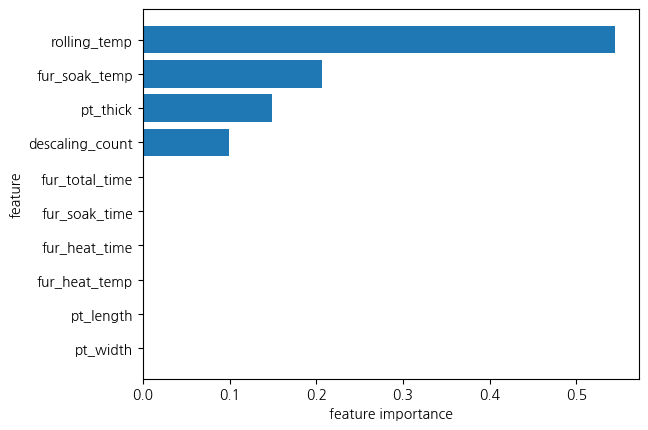

In [58]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = xgb_final.feature_importances_
df_importance = df_importance[:10]
df_importance.sort_values('Importance',ascending = True, inplace = True)
coordinates = range(len(df_importance))

plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('feature importance')
plt.ylabel('feature')

- xgboost 모델링 결과, 불량 여부에 영향을 미치는 요소는 압연 온도, 가열대 소재 온도, 지시 두께, 압연 횟수이다.
- 의사결정나무, 랜덤포레스트의 결과와 동일하게 압연 온도가 가장 중요하다는 결과가 나왔고
- 지시 두께, 압연횟수도 중요하다는 결과가 나왔다.

In [59]:
y_test_pred = xgb_final.predict(df_test_x)
cf_xgb = confusion_matrix(df_test_y,y_test_pred)

tpr = cf_xgb[1][0] /(cf_xgb[1][0] + cf_xgb[1][1])
tpr
print(1-tpr)

0.9411764705882353


In [60]:
y_train_pred = xgb_final.predict(df_train_x)
print('Train 성능')
print(eval_class_model(df_train_y,y_train_pred))

y_test_pred = xgb_final.predict(df_test_x)
print('\nTest 성능')
print(eval_class_model(df_test_y,y_test_pred))

Train 성능
혼돈행렬 : 
[[370   0]
 [  6 196]]
accuracy : 0.9895
precision : 1.0000
recall : 0.9849
f1 : 0.9849
AUC : 0.9851
None

Test 성능
혼돈행렬 : 
[[93  0]
 [ 3 48]]
accuracy : 0.9792
precision : 1.0000
recall : 0.9697
f1 : 0.9697
AUC : 0.9706
None


1. test의 accuracy _감소_
2. test의 precision _유지_
3. test의 reacll _감소_
4. test의 F1-score _감소_
5. test의 AUC _감소_

소폭 감소로 모델 성능에 문제가 없는 것으로 판단된다

In [61]:
xgb_pred = xgb_final.predict(df_test_x)

accuracy.append(accuracy_score(df_test_y,xgb_pred))
f1.append(f1_score(df_test_y,xgb_pred))
recall.append(recall_score(df_test_y, xgb_pred))
precision.append(precision_score(df_test_y,xgb_pred))
speci.append(1-tpr)

## 4. 로지스틱 회귀

- 데이터 분리

In [62]:
df_train, df_test, df_train_y, df_test_y = train_test_split(df_r, df_r[["y"]] ,
                                      test_size = 0.2,random_state = 2024)

print(f"train data size : {df_train.shape}")
print(f"test data size : {df_test.shape}")

train data size : (572, 17)
test data size : (144, 17)


- 모델 생성<br>

모델링 후 p-value가 높은 (유의하지 않은) 변수들은 제거

In [63]:
fx = "y ~ + " + "+".join(df_train.columns[1:])
fx = "y ~ pt_thick+pt_width+pt_length+fur_heat_temp+fur_heat_time+fur_soak_temp+fur_soak_time+fur_total_time+rolling_temp+descaling_count+프랑스+미국+영국+일본+한국+독일"
log_model = Logit.from_formula(fx, df_train,random_state = 2024)
log_result = log_model.fit()
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.370557
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  572
Model:                          Logit   Df Residuals:                      556
Method:                           MLE   Df Model:                           15
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.4321
Time:                        22:01:33   Log-Likelihood:                -211.96
converged:                       True   LL-Null:                       -373.22
Covariance Type:            nonrobust   LLR p-value:                 1.145e-59
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.1301   1.78e+07  -6.33e-08      1.000    -3.5e+07     3.5e+07
pt_thick      

독일 삭제

In [64]:
fx = "y ~ pt_thick+pt_width+pt_length+fur_heat_temp+fur_heat_time+fur_soak_temp+fur_soak_time+fur_total_time+rolling_temp+descaling_count+프랑스+미국+영국+일본+한국"
log_model = Logit.from_formula(fx, df_train)
log_result = log_model.fit()
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.370557
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  572
Model:                          Logit   Df Residuals:                      556
Method:                           MLE   Df Model:                           15
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.4321
Time:                        22:01:33   Log-Likelihood:                -211.96
converged:                       True   LL-Null:                       -373.22
Covariance Type:            nonrobust   LLR p-value:                 1.145e-59
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.8922      0.364     -2.451      0.014      -1.606      -0.179
pt_thick      

_fur_soak_time_ 삭제

In [65]:
fx = "y ~ pt_thick+pt_width+pt_length+fur_heat_temp+fur_heat_time+fur_soak_temp+fur_total_time+rolling_temp+descaling_count+프랑스+미국+영국+일본+한국"
log_model = Logit.from_formula(fx, df_train)
log_result = log_model.fit()
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.370567
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  572
Model:                          Logit   Df Residuals:                      557
Method:                           MLE   Df Model:                           14
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.4321
Time:                        22:01:33   Log-Likelihood:                -211.96
converged:                       True   LL-Null:                       -373.22
Covariance Type:            nonrobust   LLR p-value:                 2.347e-60
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.8928      0.364     -2.452      0.014      -1.606      -0.179
pt_thick      

_영국_ 삭제

In [66]:
fx = "y ~ pt_thick+pt_width+pt_length+fur_heat_temp+fur_heat_time+fur_soak_temp+fur_total_time+rolling_temp+descaling_count+프랑스+미국+일본+한국"
log_model = Logit.from_formula(fx, df_train)
log_result = log_model.fit()
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.370686
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  572
Model:                          Logit   Df Residuals:                      558
Method:                           MLE   Df Model:                           13
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.4319
Time:                        22:01:33   Log-Likelihood:                -212.03
converged:                       True   LL-Null:                       -373.22
Covariance Type:            nonrobust   LLR p-value:                 4.921e-61
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.0043      0.204     -4.921      0.000      -1.404      -0.604
pt_thick      

_일본_ 삭제

In [67]:
fx = "y ~ pt_thick+pt_width+pt_length+fur_heat_temp+fur_heat_time+fur_soak_temp+fur_total_time+rolling_temp+descaling_count+프랑스+미국+한국"
log_model = Logit.from_formula(fx, df_train)
log_result = log_model.fit()
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.370774
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  572
Model:                          Logit   Df Residuals:                      559
Method:                           MLE   Df Model:                           12
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.4318
Time:                        22:01:33   Log-Likelihood:                -212.08
converged:                       True   LL-Null:                       -373.22
Covariance Type:            nonrobust   LLR p-value:                 9.733e-62
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.0380      0.175     -5.938      0.000      -1.381      -0.695
pt_thick      

_미국_ 삭제

In [68]:
fx = "y ~ pt_thick+pt_width+pt_length+fur_heat_temp+fur_heat_time+fur_soak_temp+fur_total_time+rolling_temp+descaling_count+프랑스+한국"
log_model = Logit.from_formula(fx, df_train)
log_result = log_model.fit()
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.370872
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  572
Model:                          Logit   Df Residuals:                      560
Method:                           MLE   Df Model:                           11
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.4316
Time:                        22:01:33   Log-Likelihood:                -212.14
converged:                       True   LL-Null:                       -373.22
Covariance Type:            nonrobust   LLR p-value:                 1.850e-62
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.0613      0.161     -6.600      0.000      -1.376      -0.746
pt_thick      

_fur_total_time_ 삭제

In [69]:
fx = "y ~ pt_thick+pt_width+pt_length+fur_heat_temp+fur_heat_time+fur_soak_temp+rolling_temp+descaling_count+프랑스+한국"
log_model = Logit.from_formula(fx, df_train)
log_result = log_model.fit()
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.372155
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  572
Model:                          Logit   Df Residuals:                      561
Method:                           MLE   Df Model:                           10
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.4296
Time:                        22:01:34   Log-Likelihood:                -212.87
converged:                       True   LL-Null:                       -373.22
Covariance Type:            nonrobust   LLR p-value:                 6.483e-63
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.0379      0.157     -6.594      0.000      -1.346      -0.729
pt_thick      

_pt_thick_ 삭제

In [70]:
fx = "y ~ pt_width+pt_length+fur_heat_temp+fur_heat_time+fur_soak_temp+rolling_temp+descaling_count+프랑스+한국"
log_model = Logit.from_formula(fx, df_train)
log_result = log_model.fit()
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.372784
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  572
Model:                          Logit   Df Residuals:                      562
Method:                           MLE   Df Model:                            9
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.4287
Time:                        22:01:34   Log-Likelihood:                -213.23
converged:                       True   LL-Null:                       -373.22
Covariance Type:            nonrobust   LLR p-value:                 1.498e-63
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.0266      0.157     -6.531      0.000      -1.335      -0.718
pt_width      

_한국_ 삭제

In [71]:
fx = "y ~ pt_width+pt_length+fur_heat_temp+fur_heat_time+fur_soak_temp+rolling_temp+descaling_count+프랑스"
log_model = Logit.from_formula(fx, df_train)
log_result = log_model.fit()
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.374132
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  572
Model:                          Logit   Df Residuals:                      563
Method:                           MLE   Df Model:                            8
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.4266
Time:                        22:01:34   Log-Likelihood:                -214.00
converged:                       True   LL-Null:                       -373.22
Covariance Type:            nonrobust   LLR p-value:                 4.875e-64
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.0842      0.151     -7.187      0.000      -1.380      -0.789
pt_width      

_프랑스_삭제

In [72]:
fx = "y ~ pt_width+pt_length+fur_heat_temp+fur_heat_time+fur_soak_temp+rolling_temp+descaling_count"
log_model = Logit.from_formula(fx, df_train)
log_result = log_model.fit()
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.376467
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  572
Model:                          Logit   Df Residuals:                      564
Method:                           MLE   Df Model:                            7
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.4230
Time:                        22:01:34   Log-Likelihood:                -215.34
converged:                       True   LL-Null:                       -373.22
Covariance Type:            nonrobust   LLR p-value:                 2.589e-64
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.1354      0.149     -7.626      0.000      -1.427      -0.844
pt_width      

_fur_heat_temp_ 제거

In [73]:
fx = "y ~ pt_width+pt_length+fur_heat_time+fur_soak_temp+rolling_temp+descaling_count"
log_model = Logit.from_formula(fx, df_train)
log_result = log_model.fit()
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.378930
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  572
Model:                          Logit   Df Residuals:                      565
Method:                           MLE   Df Model:                            6
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.4193
Time:                        22:01:34   Log-Likelihood:                -216.75
converged:                       True   LL-Null:                       -373.22
Covariance Type:            nonrobust   LLR p-value:                 1.372e-64
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.1728      0.150     -7.800      0.000      -1.468      -0.878
pt_width      

#### 최종모델

In [74]:
fx = "y ~ pt_width+pt_length+fur_heat_time+fur_soak_temp+rolling_temp+descaling_count"
log_model = Logit.from_formula(fx, df_test)
log_result = log_model.fit()
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.328851
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  144
Model:                          Logit   Df Residuals:                      137
Method:                           MLE   Df Model:                            6
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.4834
Time:                        22:01:34   Log-Likelihood:                -47.355
converged:                       True   LL-Null:                       -91.658
Covariance Type:            nonrobust   LLR p-value:                 5.898e-17
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.8137      0.405     -4.482      0.000      -2.607      -1.021
pt_width      

### 최종 회귀식<br>
#### log(p/(1-p)) = -1.8137 -0.7694 * pt_width -0.4302 * pt_length + 0.5227 * fur_heat_time + 1.5911 * fur_soak_temp + 1.3481 * rolling_temp -0.6708 * descaling_countount


In [75]:
# 실제 불량을 불량으로 잘 예측할 확률
lr_pred = log_result.predict(df_test)
y_pred_class = (lr_pred > 0.5).astype(int)

cf_lr = confusion_matrix(df_test['y'],y_pred_class)
tpr = cf_lr[1][0] /(cf_lr[1][0] + cf_lr[1][1])
1-tpr

accuracy.append(accuracy_score(df_test['y'],y_pred_class))
f1.append(f1_score(df_test['y'],y_pred_class))
recall.append(recall_score(df_test['y'],y_pred_class))
precision.append(precision_score(df_test['y'],y_pred_class))
speci.append(1-tpr)


In [76]:
# 테스트 종합 성능 프린트
eval_class_model(df_test['y'],y_pred_class)

혼돈행렬 : 
[[86 10]
 [11 37]]
accuracy : 0.8542
precision : 0.7872
recall : 0.7789
f1 : 0.7789
AUC : 0.8333


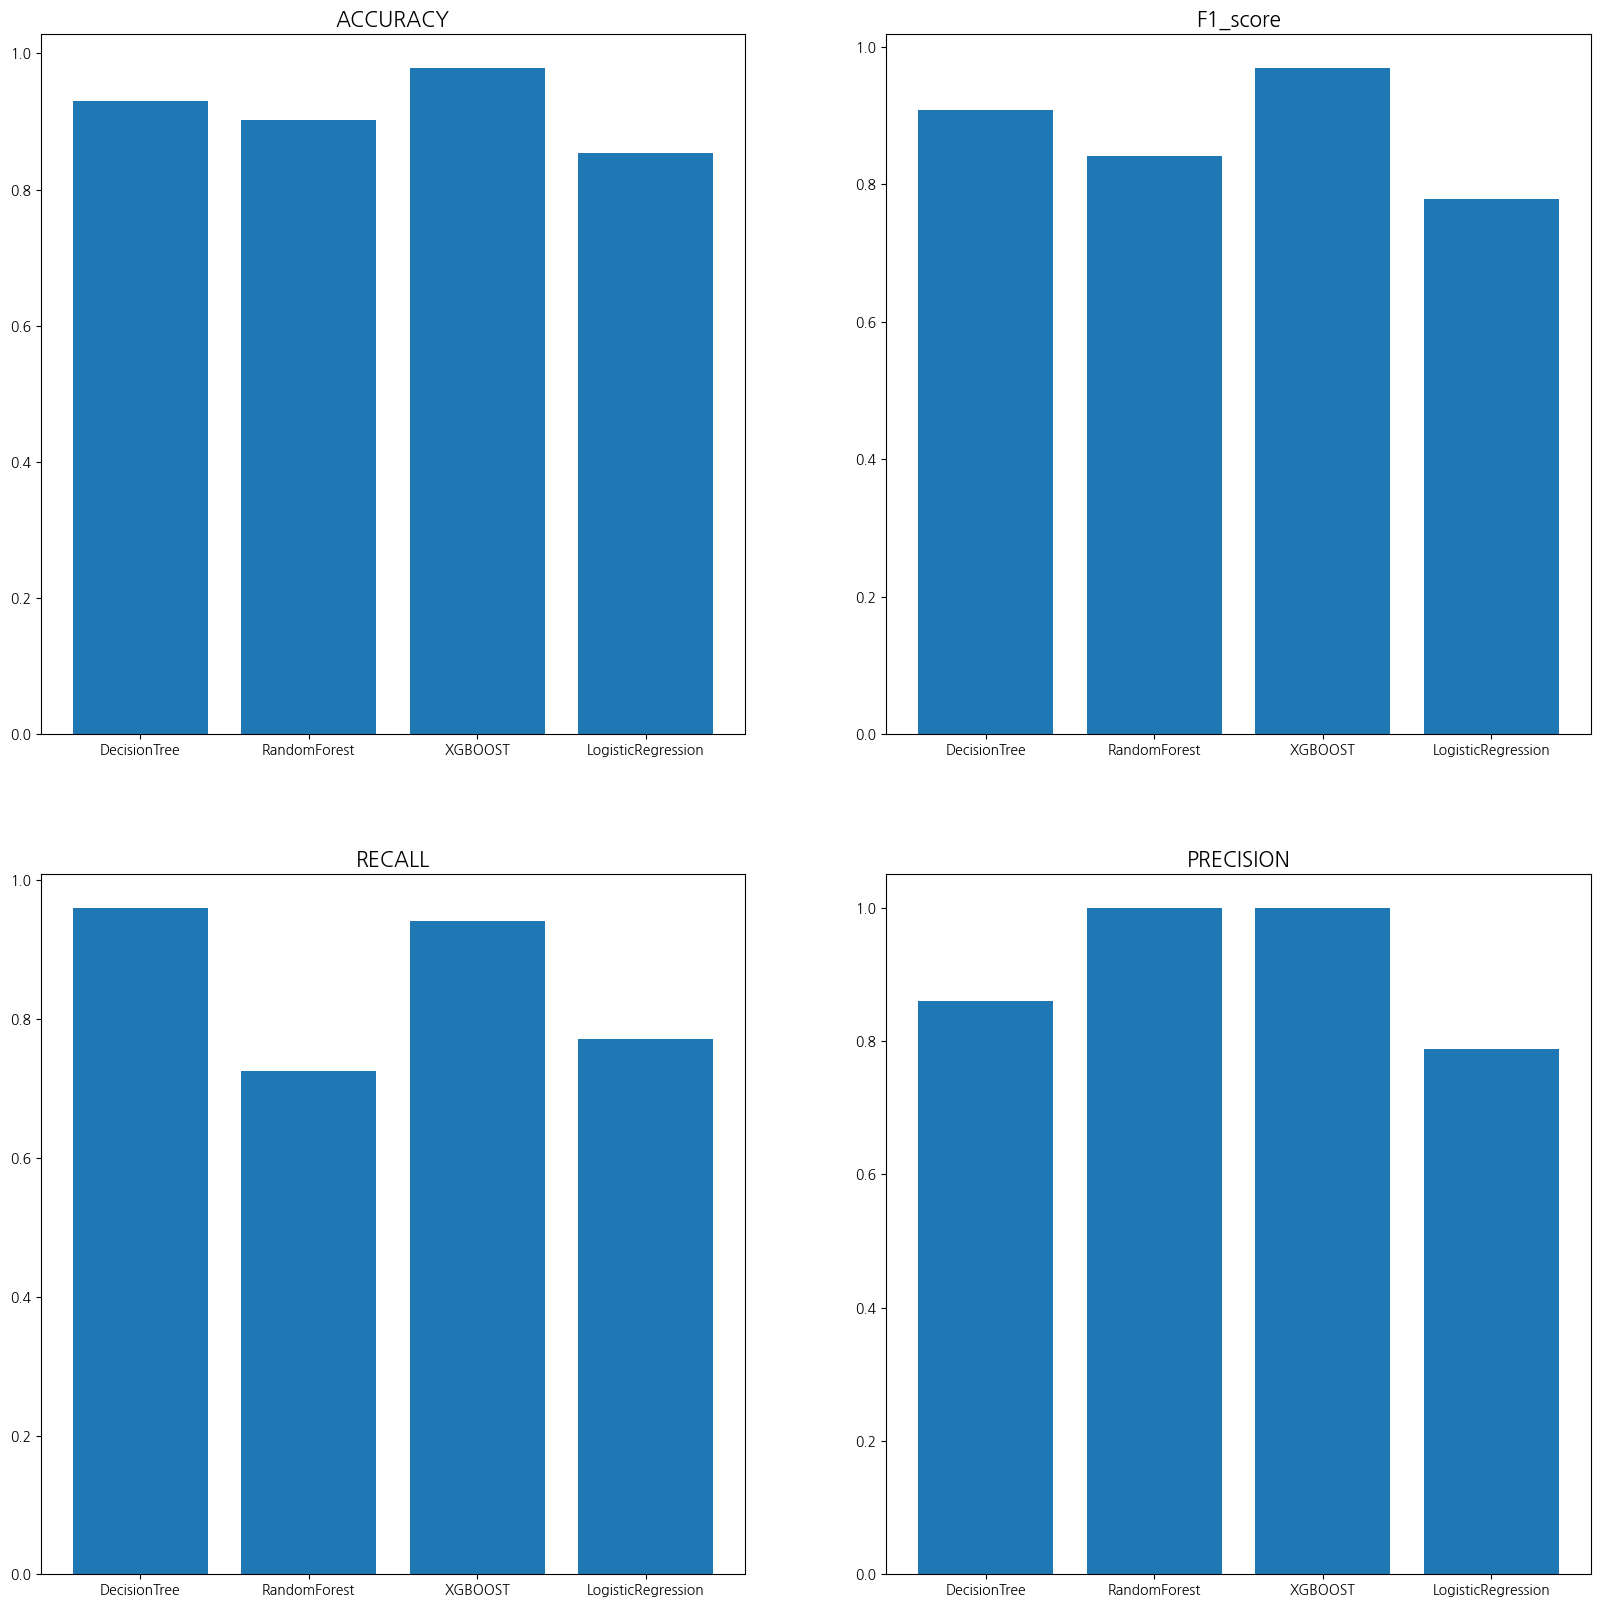

In [77]:
models = ['DecisionTree','RandomForest','XGBOOST','LogisticRegression']

fig,ax = plt.subplots(nrows = 2, ncols =2 , figsize = (20,20))
ax[0,0].bar(models, accuracy)
ax[0,0].set_title('ACCURACY').set_fontsize(15)

ax[0,1].bar(models,f1)
ax[0,1].set_title('F1_score').set_fontsize(15)

ax[1,0].bar(models,recall)
ax[1,0].set_title('RECALL').set_fontsize(15)

ax[1,1].bar(models,precision)
ax[1,1].set_title('PRECISION').set_fontsize(15)

- 정확도 : xgboost가 가장 우수
- f1스코어 : xgboost가 가장 우수
- 재현율 : 의사결정나무가 가장 우수
- 정밀도 : 랜덤포레스트와 xgboost가 우수

Text(0.5, 1.0, 'SPECIFICITY')

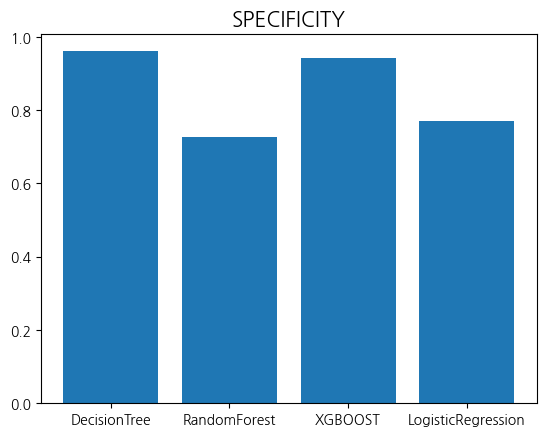

In [78]:
# 특이도

plt.bar(models,speci)
plt.title('SPECIFICITY',fontsize = 15)

### 결론

- xgboost와 의사결정나무가 실제 불량인 제품을 불량으로 잘 예측한다.
- 기업 입장에서 불량인 제품을 양품으로 판단해 출고하는 것은 여러모로 손실이 크기 때문에
- 특이도가 뛰어난 의사결정나무와 xgboost를 후판공정 스케일 불량을 예측하고 분석하는 모델로 활용한다.